In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from loadVid import loadVid

(440, 350)

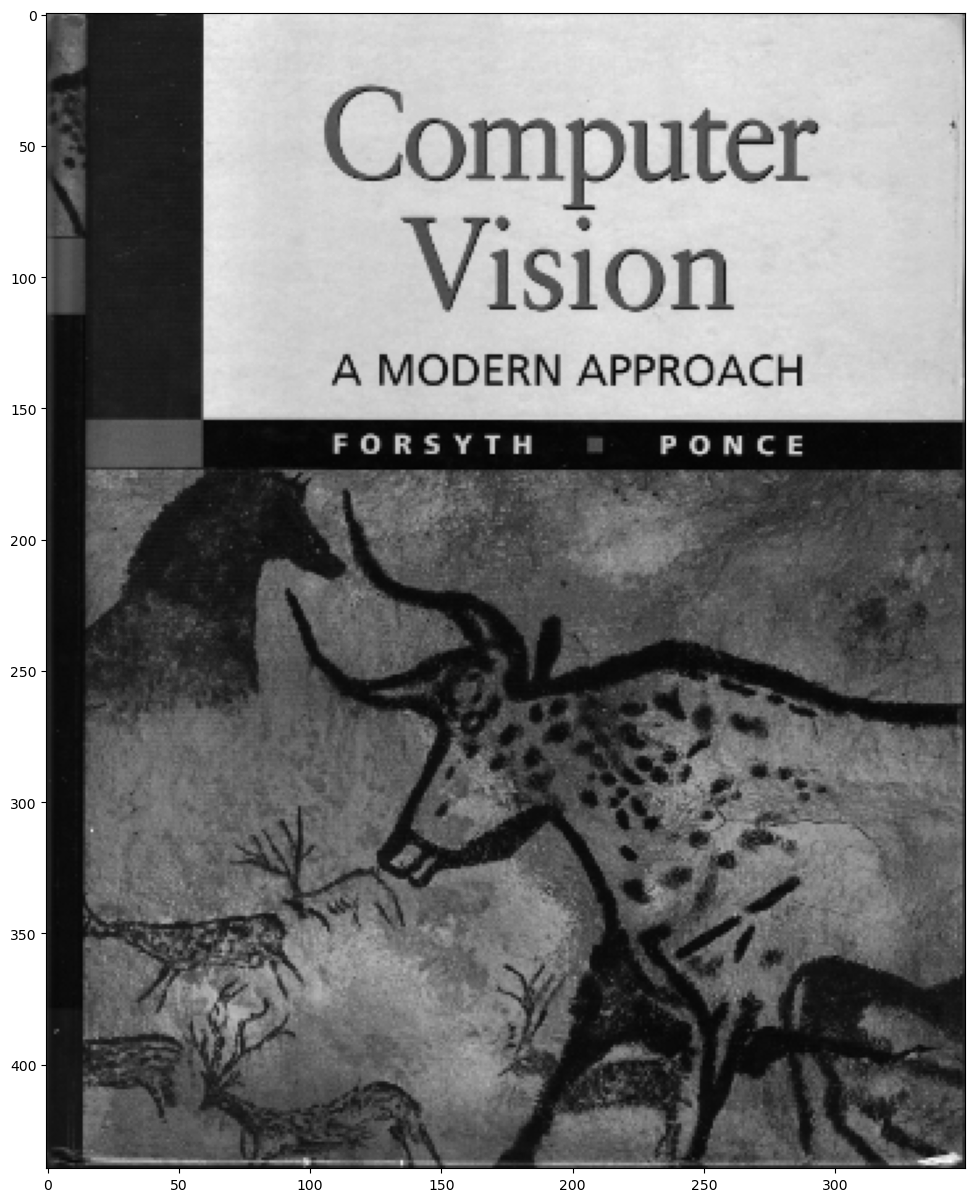

In [4]:
book_gray = cv2.imread("./cv_cover.jpg", cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(15, 15))
plt.imshow(book_gray, cmap="gray")

book_gray.shape

In [3]:
book_frames = loadVid("./book.mov")
book_frames.shape

(641, 480, 640, 3)

In [4]:
panda_frames = loadVid("./ar_source.mov")
panda_frames.shape

(511, 360, 640, 3)

In [5]:
frames_count = min(panda_frames.shape[0], book_frames.shape[0])
frames_count

511

In [6]:
# function to detect the features by finding key points and descriptors from the image
def detector(image):
    # creating SIFT detector
    sift = cv2.SIFT_create()

    # finding key points and descriptors of both images using detectAndCompute() function
    key_points, descriptors = sift.detectAndCompute(image, None)

    return key_points, descriptors

In [7]:
def DrawKeypoints(image, key_points):
    _features_img = np.zeros(shape=image.shape)

    _features_img = cv2.drawKeypoints(image, key_points, _features_img)

    return _features_img

In [8]:
# function to find best detected features using brute force
# matcher and match them according to there humming distance
def BF_FeatureMatcher(des1, des2, threshold=0.35):
    # brute_force = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    # _matches = brute_force.match(des1, des2)

    brute_force = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_BRUTEFORCE)
    _matches = brute_force.knnMatch(des1, des2, k=2)

    # Sort them in the order of their distance.
    good = []
    for m, n in _matches:
        if m.distance < threshold * n.distance:
            good.append(m)

    good = sorted(good, key=lambda x: x.distance)

    return good


In [9]:
def Flann_FeatureMatcher(des1, des2, threshold=0.35):
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    # matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    _matches = flann.knnMatch(des1, des2, k=2)

    good = []
    for m, n in _matches:
        if m.distance < threshold * n.distance:
            good.append(m)

    good = sorted(good, key=lambda x: x.distance)

    return good

(2.790301561355591, 39.857112884521484)

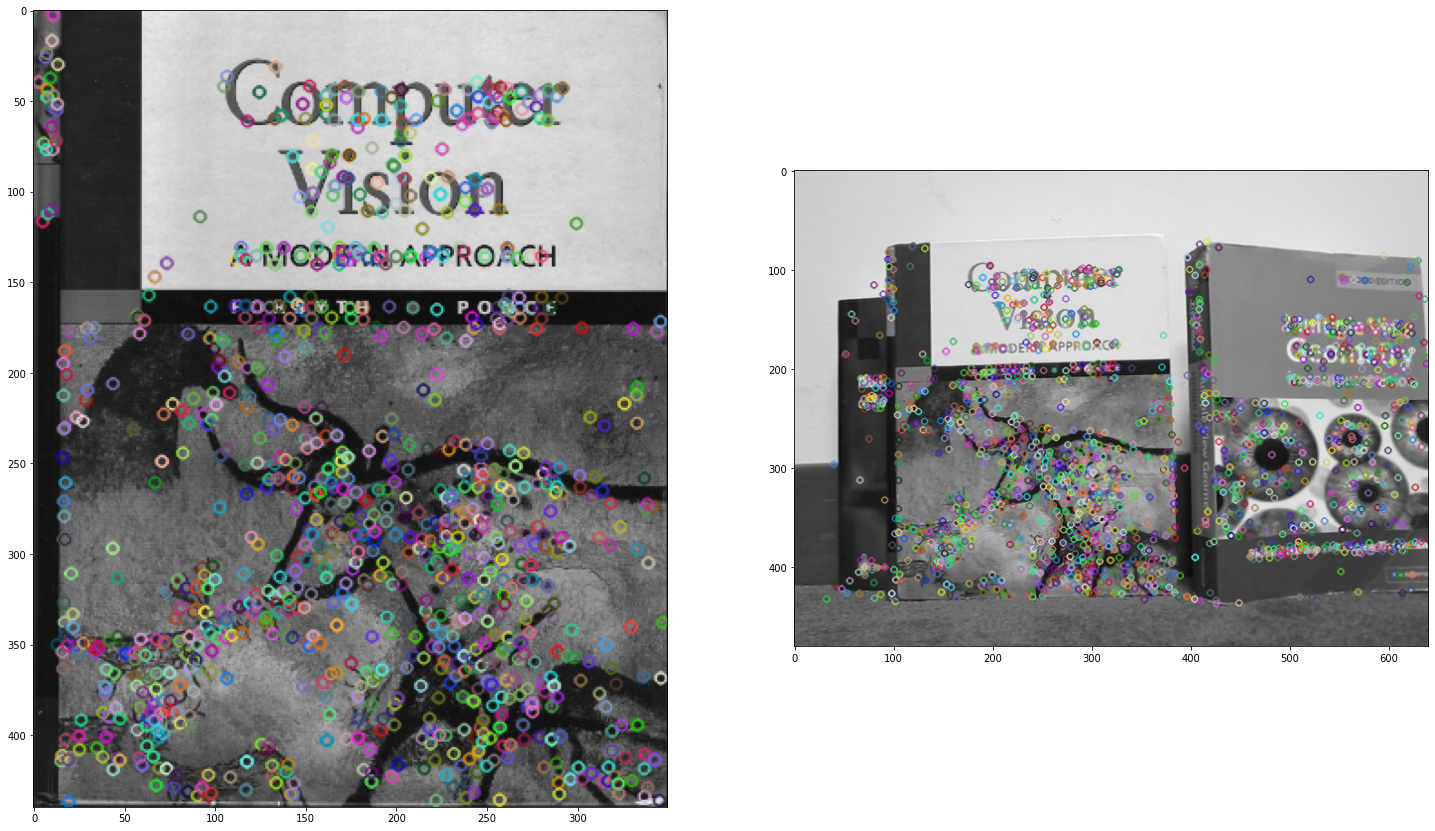

In [10]:
frame_gray = cv2.cvtColor(book_frames[50], cv2.COLOR_BGR2GRAY)

features_1, descriptor_1 = detector(book_gray)
features_2, descriptor_2 = detector(frame_gray)

features_img_1 = DrawKeypoints(book_gray, features_1)
features_img_2 = DrawKeypoints(frame_gray, features_2)

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
ax = ax.flatten()
ax[0].imshow(features_img_1, cmap="gray")
ax[1].imshow(features_img_2, cmap="gray")

features_1[0].pt  # cv2.KeyPoint

185

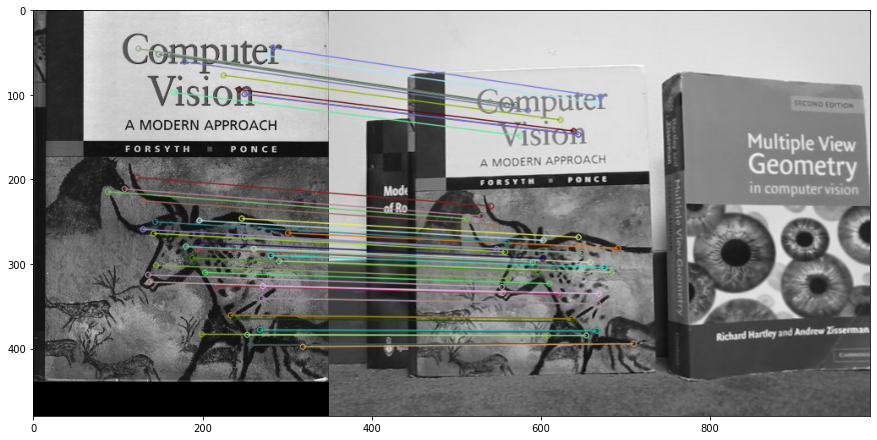

In [11]:
matches = Flann_FeatureMatcher(descriptor_1, descriptor_2)

output_image = cv2.drawMatches(book_gray, features_1, frame_gray, features_2, matches[0:50], None, flags=2)

plt.figure(figsize=(15, 15))
plt.imshow(output_image, cmap="gray")

#matches[0].queryIdx  # cv2.DMatch
len(matches)

In [12]:
def getCorrespondences(_src, _matches, _features_1, _features_2):
    src_pts = np.float32([_features_1[match.queryIdx].pt for match in _matches]).reshape(-1, 1, 2)

    dst_pts = np.float32([_features_2[match.trainIdx].pt for match in _matches]).reshape(-1, 1, 2)

    M, mask = cv2.findHomography(src_pts, dst_pts)  #, cv2.RANSAC, 5.0

    h, w = _src.shape
    pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)

    _dst_points = cv2.perspectiveTransform(pts, M)

    _dst_points = np.int32(_dst_points)

    return _dst_points, M


In [13]:
def findHomography_scratch(src_pts, dst_pts):
    # define similarity transformation
    # no rotation, scaling using sdv and setting centroid as origin

    mean = np.mean(src_pts, axis=0)
    mx = mean[0]
    my = mean[1]
    distances = 0
    for i in range(src_pts.shape[0]):
        distances += np.sqrt((src_pts[i][0] - mx) ** 2 + (src_pts[i][1] - my) ** 2)

    s = np.sqrt(2.0) * src_pts.shape[0] / distances  # np.sqrt(2.0) *

    T = np.array([[s, 0, -mx*s],
                  [0, s, -my*s],
                  [0, 0, 1]])

    # convert to homogenous coordinates
    src_pts = np.c_[src_pts, np.ones(src_pts.shape[0])]
    # apply the transformation
    src_pts = np.dot(T, src_pts.T).T

    mean = np.mean(dst_pts, axis=0)
    mx = mean[0]
    my = mean[1]
    distances = 0
    for i in range(dst_pts.shape[0]):
        distances += np.sqrt((dst_pts[i][0] - mx) ** 2 + (dst_pts[i][1] - my) ** 2)

    s = np.sqrt(2.0) * dst_pts.shape[0] / distances  # np.sqrt(2.0) *

    T_prime = np.array([[s, 0, -mx*s],
                        [0, s, -my*s],
                        [0, 0, 1]])

    # convert to homogenous coordinates
    dst_pts = np.c_[dst_pts, np.ones(dst_pts.shape[0])]
    # apply the transformation
    dst_pts = np.dot(T_prime, dst_pts.T).T

    A = []
    for correspondence in range(src_pts.shape[0]):
        x, y = src_pts[correspondence][0], src_pts[correspondence][1]
        x_dash, y_dash = dst_pts[correspondence][0], dst_pts[correspondence][1]

        A.append([-x, -y, -1, 0, 0, 0, x * x_dash, y * x_dash, x_dash])
        A.append([0, 0, 0, -x, -y, -1, x * y_dash, y * y_dash, y_dash])

    A = np.asarray(A)

    U, S, V = np.linalg.svd(A)

    H_tilde = V[-1, :].reshape(3, 3)

    # denormalize to obtain homography (H) using the transformations and generalized pseudo-inverse
    H = np.dot(np.linalg.inv(T_prime), np.dot(H_tilde, T))

    H /= H[2, 2]

    return H

In [14]:
def getCorrespondences_scratch(_src, _matches, _features_1, _features_2):

    src_pts = np.float32([_features_1[match.queryIdx].pt for match in _matches]).squeeze()

    dst_pts = np.float32([_features_2[match.trainIdx].pt for match in _matches]).squeeze()

    H = findHomography_scratch(src_pts, dst_pts)

    h, w = _src.shape
    pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)

    _dst_points = cv2.perspectiveTransform(pts, H)
    _dst_points = np.int32(_dst_points)

    return _dst_points, H

In [15]:
def overlay(_H, _ar_frame, _book_frame):
    x = _ar_frame.shape[1] / 2 - book_gray.shape[1] / 2
    _ar_frame = _ar_frame[45:_ar_frame.shape[0] - 45, int(x):_ar_frame.shape[1] - int(x), :]  # remove black headers
    _ar_frame = cv2.resize(_ar_frame, book_gray.shape[::-1])  # reverse order (y,x) -> (x,y)

    for i in range(_ar_frame.shape[0]):# y
        for j in range(_ar_frame.shape[1]):# x
            point = np.matmul(_H, (j, i, 1))

            x = round(point[1]  / point[2])
            y = round(point[0]  / point[2])

            if x >= 0 and y >= 0:
                _book_frame[x, y, :] = _ar_frame[i, j,:]

    return _book_frame

In [16]:
def overlay_corners(_points, _ar_frame, _book_frame):

    _ar_frame = _ar_frame[45:_ar_frame.shape[0] - 45, :, :]  # remove black headers
    _ar_frame = cv2.resize(_ar_frame, (360, 640))  # reverse order (y,x) -> (x,y)

    x1, y1 = _points[0][0]  # top left
    x2, y2 = _points[1][0]  # bottom left
    x3, y3 = _points[2][0]  # bottom right
    x4, y4 = _points[3][0]  # top right

    x1 = max(x1, 0)
    y1 = max(y1, 0)

    x2 = x1
    y2 = min(max(y2, 0), 480)

    x3 = min(x3, 640)
    y3 = min(y3, 480)

    x4 = x3
    y4 = y1

    h1 = min(y2 - y1, 360)  # left height
    w1 = x4 - x1  # top width

    h2 = min(y3 - y4, 360)  # right height
    w2 = x3 - x2  # bottom width

    center = _ar_frame.shape
    x = center[1] / 2 - w2 / 2
    y = center[0] / 2 - h1 / 2

    crop_img = _ar_frame[int(y):int(y + h1), int(x):int(x + w2), :]

    _book_frame[int(y1):int(y1 + h1), int(x1):int(x3), :] = crop_img

    return _book_frame

In [17]:
out = cv2.VideoWriter('verification.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 24, (640, 480))

In [18]:
features_1, descriptor_1 = detector(book_gray)

for i in range(frames_count):
    book_frame_gray = cv2.cvtColor(book_frames[i], cv2.COLOR_BGR2GRAY)

    features_2, descriptor_2 = detector(book_frame_gray)

    total_matches = 0
    min_threshold = 0.2
    min_matches = 50

    while total_matches < min_matches:
        matches = Flann_FeatureMatcher(descriptor_1, descriptor_2, min_threshold)
        total_matches = len(matches)

        if min_threshold > 0.6:
            min_matches -= 5
        else:
            min_threshold += 0.05

    dst_corner_points, Homography = getCorrespondences(book_gray, matches, features_1, features_2)

    # overlay_frame = overlay(Homography, panda_frames[i].copy(), book_frames[i].copy())
    overlay_frame = overlay_corners(dst_corner_points, panda_frames[i].copy(), book_frames[i].copy())

    out.write(overlay_frame)

out.release()